# First Principles of a Transit Systems

By Will Roscoe - [wroscoe.com](http:wroscoe.com) 

This document attempts to model and evaluate the essential nature of transit systems using simulations writen in python. I'll use these models to explore the first principles of transit. **First priciples** are the fundamental properties of a system that determine it's behavior. [Elon musk used these to explain why batteries and space travel could become much cheaper](http://www.businessinsider.com/elon-musk-first-principles-2015-1).

Here I've tried to quantify the assumptions so they can be challenged explicity. 


## Approach 

This is a difficult problem because there are many factors that influence the behavior of a transit system. To simplify the simulation, we'll only model the most essentional objects and processs of transit. 
First lets define the terms we'll be using: 

#### Objects
1. **rider** - a person with a destination (end stop)
2. **vehicle** - the container that moves riders to their end stop along a path
3. **path** - how vehicles can move between stops
4. **stop** - a point along a route where a vehicle can load/unload riders
 
#### Processes
1. **move** - a vehicle has to move along a route
2. **unload vehicle** - riders transfered from a vehicle to a stop. 
3. **load vehicle** - riders transfered from stop to vehicle. 
4. **create new riders** - create riders that are waiting to be picked up
 
#### Key Measurments
* **trip time** - time for rider to get to their destination
* **flow** - riders passing a point over time (usually measured at each station)

#### Variables
One thing that makes transit systems tricky is that they have so many variables. changing more than one of these at a time makes it dificutle to identify which variable has the effect. 

> vehicle frequency -  vehicle capacity - number of vehicles - vehicle schedule - path shapes - number of stations - time between stations -  time vehicles spend at stop -  number of new passengers - destinations of new passengers, 




## TLDR - What we've learned.

This document includes working python code you can run and tweak on a Jupyter Notebook. Here are the key takeaways from the simulations of cbelow:  

> Larger vehicles **sometimes** reduce trip times. At a point icreasing the vehicle capacity just adds empty seats. 

> Higher vehicle frequency **always** reduces trip times.

> System flow is always less than the sysem rider demand.

## What's missing.
This document only models a fraction of the potential transit systems. You can fork and improve this document [on github](https://github.com/wroscoe/notebooks/blob/master/First%20Principles%20of%20Transit.ipynb).

* How do linear and point to point paths change system behaviro.
* How do rider demand distributions affect the performance of the network?
* Can system performance be improved with route logic? 
* Does more information (knowing where riders want to go?) allow for more efficient systems?
* Cost structures of real transit systems. How does the nature of existing transit systems allow them to improve?
* How does speed, distance, acceleration, random stops and other factors affect trip time.

# Model

## Riders
To measure wait time and efficiency we need to know where and when people want to go. For this I represent a rider as a tuple (destination stop, time trip began) and group them into a list. 


In [240]:
class Riders(list):
    def __init__(self, *args):
        list.__init__(self, *args)

    def put(self, riders):
        ''' add riders'''
        self += riders
        
    def get(self, matches=None, n=None):
        ''' 
        return n matching riders and remove them
        '''
        
        removed = []
        removed_index = []
        
        if n is None and n != 0: 
            n = len(self)
        
        if matches is None:
            removed = self[:n] #get all riders
            del self[:n] #remove riders
    

        else:
            i = 0
            for r in self:
                if i == n: break
                    
                if r[0] in matches:
                    removed.append(r)
                    removed_index.append(i)
                    i += 1
            
        for i in sorted(removed_index, reverse=True):
            del self[i]
                    
        return removed
        

In [241]:
#rider going to station A that started their journy at time 3
rider1 = ('A', 3) 
riders = Riders([rider1, ('B',4)]) 
riders.put([('C', 5)]) #add another rider
riders

[('A', 3), ('B', 4), ('C', 5)]

In [242]:
riders.get(matches=['A', 'C'], n=1)

[('A', 3)]

## Stops 
Stops are points distributed long a path where riders can waite to board vehicles.

In [243]:
class Stop():
    def __init__(self, name, riders):
        self.name = name
        self.riders = riders
        
    def load(self, riders):
        ''' add riders to the stop'''
        self.riders += riders
        
    def unload(self, n=None, matches=None):
        ''' take riders from the stop'''
        riders = self.riders.get(n=n, matches=matches)
        return riders
    

In [244]:
s = Stop('A', riders )
s.load(riders)
s.riders

[('B', 4), ('C', 5), ('B', 4), ('C', 5)]

## Paths

Paths are a representation of how a vehicle can travel. 

In [245]:
class CirclePath():
    
    def __init__(self, stop_names, durations):
        self.stops = stop_names
        self.durations = durations
        
    def next_stops(self, start):
        ''' return a list of the next possible stops and their duration'''
        index = self.stops.index(start)
        if index == len(self.stops)-1:
            index = -1
        
        S = [(self.stops[index+1], self.durations[index+1] )]
        return S

In [246]:
path = CirclePath(list('ABCDE'), [10]*5)
path.next_stops('E')

[('A', 10)]

## Vehicles
Vehicles load riders at stops and move along the path to another stop to unload riders. 

In [247]:
class Vehicle():
    def __init__(self, name, current_stop, capacity=10):
        self.name = name
        self.end_stop = current_stop #destinations
        self.t = 0 #time to destination
        self.riders = Riders() #riders object
        self.capacity = capacity #max riders
        
    def load(self, riders):
        ''' add riders to the vehicle'''
        self.riders += riders
        
    def unload(self, matches=None):
        ''' unload riders from the vehicle'''
        unloaded = self.riders.get(matches=matches)
        return unloaded
    
    def spaces(self):
        ''' return how many riders can fit in the vehicle'''
        return self.capacity - len(self.riders)
    
    def move(self):
        ''' move one step in time closer to the stop'''
        self.t -= 1
        
    def set_route(self, end_stop, t):
        ''' set route for vehicle'''
        self.end_stop = end_stop
        self.t = t     

In [248]:
v = Vehicle('car', 'B', 10)
v.riders

[]

In [249]:
v.load(riders)
v.riders

[('B', 4), ('C', 5), ('B', 4), ('C', 5)]

## Generators
Here are helper methods to create our objects. 

In [250]:
import random

def new_riders(n, stop_names, t): 
    ''' return a list of n riders with a uniform distribution of stop_names'''
    riders = []
    for i in range(n):
        stop_name = random.sample(stop_names, 1)[0]
        t=t
        riders.append((stop_name, t))
    return Riders(riders)
        

def new_vehicles(n, stop_names):
    ''' return a list of n vehicles starting at the first n stations'''
    vehicles = []
    for i in range(n):
        name = str(i)
        stop = stop_names[i]
        t = 0
        riders = new_riders(3, stop_names, 0)
        v = Vehicle(name, stop, t, riders, 20)
        vehicles.append(v)
    return vehicles


def new_stops(stop_names):
    ''' return a dictionary of stops at stop_names'''
    stops = {}
    for s in stop_names:
        riders = new_riders(3, stop_names, 0)
        stop = Stop(s,riders)
        stops[stop.name] = stop
    return stops

## Data Recorder
Instead of using print statements, here is a simple recorder class to save data dictionaries and return them as a pandas DataFrame for easy ploting and metrics.

In [251]:
import pandas as pd

class Recorder ():
    def __init__(self):
        self.records = {}
        self.columns = {}

    def save(self, name, dct={}):
        if name not in self.records.keys():
            self.records[name]=[]
        self.records[name].append(dct)
        
    def get(self, name):
        df =  pd.DataFrame(self.records[name])
        df = df.fillna(0)
        return df

In [252]:
R = Recorder()
R.save('color', {'blue': i})
for i in range(3):
    R.save('speed', {'mph': i})
    
R.get('speed') #return pandas DataFrame (use .plot() to visualize)

,mph
0,0
1,1
2,2


## Simulate.
To move through time, our simulation updates all our objects in every time. In this case we move each train forward in time 1 step, if the 

In [253]:
class Simulator():
    def __init__(self, vehicles, stops, path):
        
        self.R = Recorder()
        self.t=0 #initialize at time = 0

        #create dictionary of stop objects
        self.stops = stops

        #3 min between stops
        self.path = path 

        self.vehicles = vehicles

In [254]:

class TrainSimulator(Simulator):
    def __init__(self, vehicles, stops, path):
        super(TrainSimulator, self).__init__(vehicles, stops, path)

    
    def step(self):
        ''' Advance every object & process through one step in time. '''

        #remove passengers that have arrived at their end_stop
        for n, s in self.stops.items():
            s.unload(matches=[s.name])

        #set new routes
        for v in self.vehicles:
            if v.t == 0:#vehicle at station
                next_stop, t = self.path.next_stops(v.end_stop)[0]
                v.set_route(next_stop, t)

            #move vehicle
            v.move()


        #if vehicle is at a station
        for v in [v for v in self.vehicles if v.t <= 0]:

            #unload riders
            if v.t <= 0:
                unloaded = v.unload(v.end_stop)
                self.stops[v.end_stop].load(unloaded) #move unloaded passengers 

            #load riders
            if v.t <= 0:
                matches = [s for s in self.stops.keys() if s != v.end_stop]
                boarding = self.stops[v.end_stop].unload(n=v.spaces(), matches=matches)
                v.load(boarding)

        #generate new riders at each stop
        for n, s in self.stops.items():
            stop_choices =[s for s in self.stops.keys() if s is not n]
            s.load(new_riders(5, stop_choices , self.t))
                        
    def run(self, end_time):
        ''' run the seimulation until specified end time. '''
        
        for i in range(end_time):
            self.step()
            
            self.t += 1

            #record rider counts
            data_dict = dict([(v.name, len(v.riders)) for v in self.vehicles ])
            self.R.save('riders on vehicles', data_dict)

            #record station counts
            data_dict = dict([(n, len(s.riders)) for n, s in self.stops.items() ])
            self.R.save('riders at stops', data_dict)
            
            #record trip durations of riders that arrive at their end stops
            for n,s in self.stops.items():
                data = [{'t':self.t, 'end_stop':s.name, 'duration':self.t - r[1]} for r in s.riders if r[0] == s.name ]
                for d in data:
                    self.R.save('trip durations', d)
            
        return self.R


Now we create the objects and loop over the step for the perod of time we want to simulate.

In [255]:
import string 

def new_train_sim(num_vehicles=1, num_stops=5, vehicle_capacity=10, spacing=10):
    
    stop_names = string.ascii_uppercase[:num_stops]

    stops = new_stops(stop_names)
    
    vehicles = []
    for i in range(num_vehicles):        
        vehicles.append(Vehicle ('train %s'%i, stop_names[i], capacity=vehicle_capacity) )

    path = CirclePath(stop_names,[spacing]*num_stops)
    
    return TrainSimulator(vehicles, stops, path)


Sim = new_train_sim() #create simulation
R  = Sim.run(300) #run simulation for 300 steps


## Visualize the number of riders waiting at each stop.
Here are we visualize the number of riders at each stop over time. The capacity of the system does not support the rider demand because the number of riders waiting increases over time.

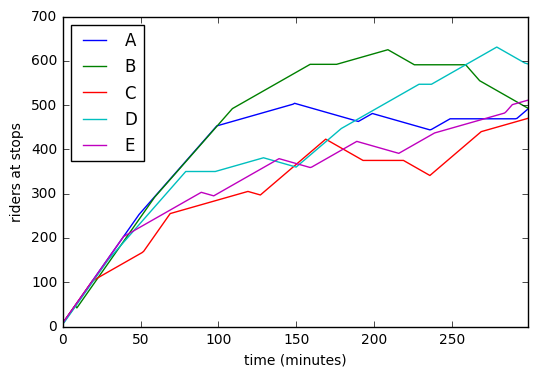

In [257]:
%matplotlib inline 

df = R.get('riders at stops')
ax = df.plot()

#set axis labels
ax.set_xlabel('time (minutes)'); ax.set_ylabel('riders at stops');

## Visualize the affects of a variable on system. 

The graph above only shows the system perforace of one variable, rider backlog. Let's create a function to show a series of visuals for simulations run with different variables. 

In [258]:
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = [10,6]
def show(var_name, choices, steps=300):
    
    TS = new_train_sim() #create sim to get the defaults
    print('Linear Circular Path Model Defaults')
    print('Vehicles: %d' % len(TS.vehicles))
    print('Vehicle Capacity %d ' % TS.vehicles[0].capacity)
    print('Stops: %d' % len(TS.stops))
    print('Time between stops: %d' % TS.path.durations[0])
    print('New riders per time step: %d' % 5)
    
    #create subplot
    fig, axes = plt.subplots(nrows=3, ncols=len(choices))
    
    for i, c in enumerate(choices):
        
        TS = new_train_sim(**{var_name: c})
        R = TS.run(steps)

        #align axes for all subplots
        xlim=[0,steps]
        ylim=[0,300]
        
        #graph of riders at stops
        df = R.get('riders at stops')
        ax = df.plot(ax=axes[0, i], title=var_name + str(c), 
                    legend=False, sharey=True, sharex=True,
                    xlim=xlim, ylim=ylim)
        ax.set_ylabel('riders at stops')

        #graph of riders on vehicles
        df = R.get('riders on vehicles')
        ax = df.plot(ax=axes[1, i],
                    legend=False, sharey=True, sharex=True,
                    xlim=xlim, ylim=ylim)
        ax.set_ylabel('riders on vehicles')
        
        #time it took each passenger to get to their destination
        df = R.get('trip durations')
        df.plot.scatter(x='t', y='duration', ax=axes[2, i], s=1,
                        legend=False, sharey=True, 
                        xlim=xlim, ylim=ylim)

    plt.tight_layout()

### Vehicle Capacity

Linear Circular Path Model Defaults
Vehicles: 1
Vehicle Capacity 10 
Stops: 5
Time between stops: 10
New riders per time step: 5


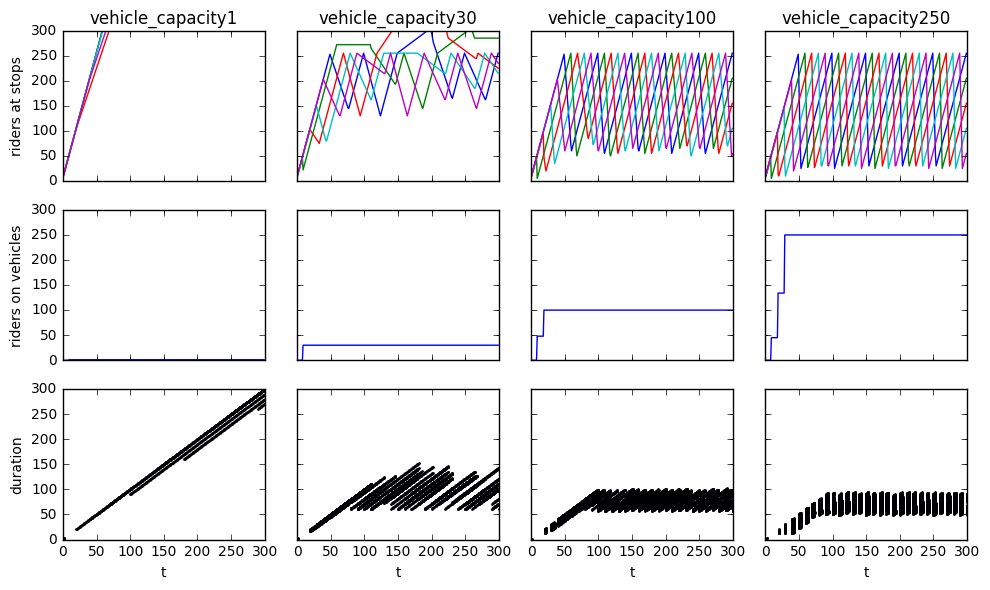

In [259]:
show('vehicle_capacity', [1, 30, 100, 250])

**Capacity=1**
* Riders are created faster than the vehicles can transport them. 

**Capacity=10**
* Riders are still created faster than they can be transported but at a slower rate.

**Capacity=100** 
* Vehicles are now big enough to carry all the riders. 

**Capacity=250** 
* The same number of riders are waiting at the station but more more people are on the train at once. 


### Vehicle Frequency

Linear Circular Path Model Defaults
Vehicles: 1
Vehicle Capacity 10 
Stops: 5
Time between stops: 10
New riders per time step: 5


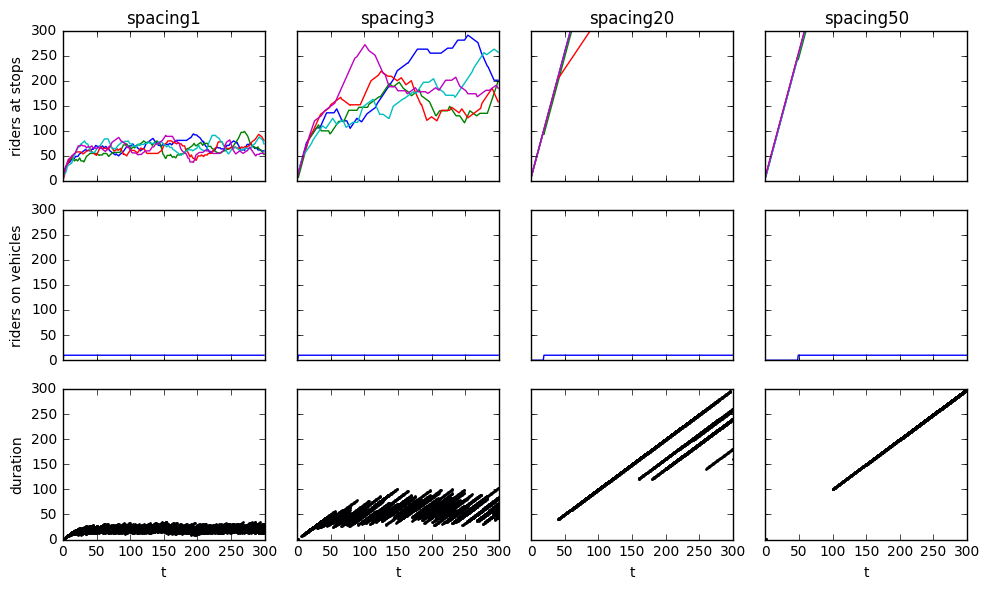

In [261]:
show('spacing',  [1, 3, 20, 50])

## New riders from distributions of destimation demand.

In [231]:
from math import cos, pi

def map_dist(name, n):
    """ return an distribution between 0 and 1 over a list of n   """
    if name == 'uniform': 
        dist = [1 for _ in range(n)] #all 1s
        
    elif name == 'peak':
        dist = [(-cos(i/n*2*pi)+1) / 2 for i in range(n)]
    return dist


## Metrics 

Even these graphs aren't arent'enough to compare the changes relative to each other. To do this, we'll generate all the combinations simulation variables we want to measure, run the simulation with those variables and then record the measurements of the last 50 timesteps. 

In [232]:
Sim = new_train_sim ()
R = Sim.run(100)

df = R.get('riders at stops')
df.tail(5)

,A,B,C,D,E
95,299,398,359,366,409
96,300,401,363,367,410
97,301,404,367,368,411
98,302,407,371,369,412
99,303,410,375,370,413


In [233]:
#make a single metric from the last time steps
df.tail(10).mean().sum() #average riders waiting at stops for last 10 timesteps

1826.0

In [278]:
import itertools 

V = {
     'spacing': [1, 3, 20, 40],
     'vehicle_capacity': [1, 5, 10, 30, 50],
     'num_vehicles': [1, 2, 3, 4],
     'num_stops': [5, 10]
    }

combinations = list(itertools.product( *V.values() ) )

combo_list = []
sim_time = 500
window = 100 #metrics come from the last window of time

for i, combo in enumerate(combinations):
    
    print()
    combo = dict(zip(V.keys(), combo))
    Sim = new_train_sim (**combo)
    R = Sim.run(sim_time)
     
    df = R.get("trip durations")
    trip_duration = df[df['t']>sim_time-window]['duration'].mean()
    
    trips = len(df[df['t']>sim_time-window])
    
    combo['ave trip duration'] = trip_duration
    combo['trips'] = trips
    combo_list.append(combo)
    
metrics = pd.DataFrame(combo_list)



In [301]:
metrics.sort_values('trips').head()

,ave trip duration,num_stops,num_vehicles,spacing,trips,vehicle_capacity
15,455.057471,10,2,40,261,1
7,457.659574,10,1,40,282,1
39,448.689076,10,1,40,357,5
5,438.500000,10,1,20,368,1
6,452.470309,5,1,40,421,1


## Interpreting the Results

In [302]:
from pandas.tools.plotting import scatter_matrix
#scatter_matrix(metrics, alpha=0.2, figsize=(10, 10), diagonal='kde')

print('Variable Correlations')
metrics.corr()

Variable Correlations


,ave trip duration,num_stops,num_vehicles,spacing,trips,vehicle_capacity
ave trip duration,1.000000,0.294499,-1.732798e-01,7.964563e-01,-0.405027,-2.942993e-01
num_stops,0.294499,1.000000,0.000000e+00,0.000000e+00,0.516271,0.000000e+00
num_vehicles,-0.173280,0.000000,1.000000e+00,0.000000e+00,0.159940,1.299078e-17
spacing,0.796456,0.000000,0.000000e+00,1.000000e+00,-0.447169,5.920546e-17
trips,-0.405027,0.516271,1.599400e-01,-4.471685e-01,1.000000,3.644382e-01
vehicle_capacity,-0.294299,0.000000,1.299078e-17,5.920546e-17,0.364438,1.000000e+00


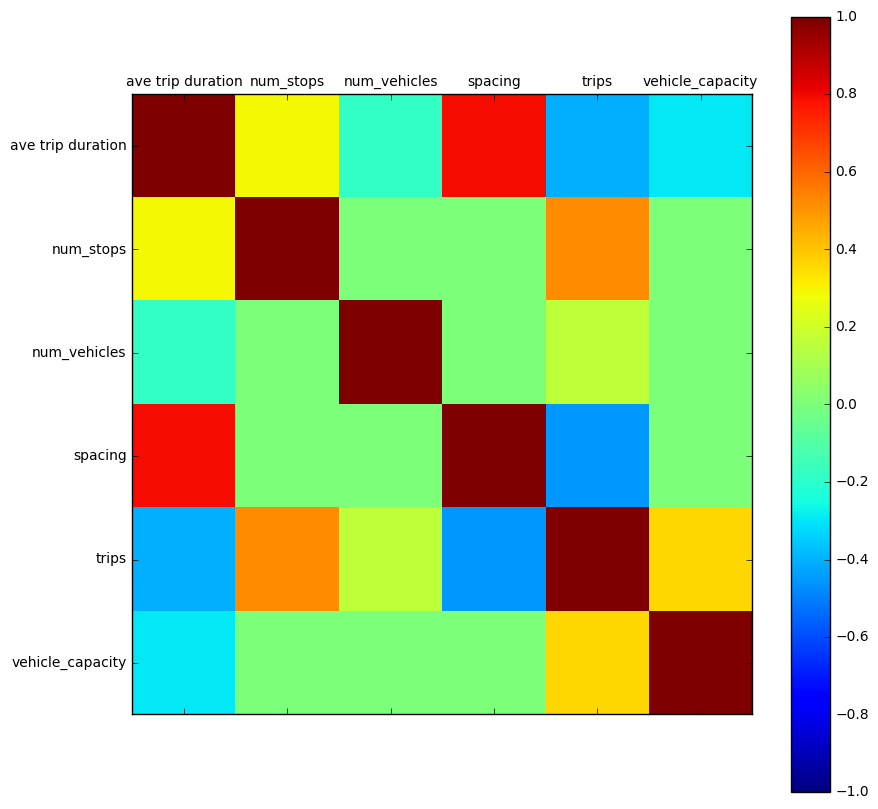

In [304]:
# Correction Matrix Plot
import numpy as np

names = metrics.columns.values
correlations = metrics.corr()

# plot correlation matrix
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()